In [1]:
import numpy as np
import pandas as pd
import os
import pickle
import sys
sys.path.append('/home/victoria/NeuroConn')
sys.path.append('/home/victoria/surfdist')
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, PolynomialFeatures
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.decomposition import PCA
from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, KFold
from NeuroConn.preprocessing.preprocessing import FmriPreppedDataSet
import seaborn as sns
from utils import *

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [2]:
data = pd.read_csv("SIFI_full.csv")
data = data[(data["FlashType"] == 1) | (data["FlashType"] == 2)]
data = data[data["NrBeeps"] == 2]
data = data.drop(["correct", "rt","correct_abs", "rt_abs", "rt_Cod","rt_rel", "bl_correct","bl_rt", "CFF", "NrBeeps"], axis=1, index=None)

In [3]:
# rename columns
# data = data.rename(columns={"participant_id": '0', "FlashType": "1", "correct_rel": "2", "sex": "3", "age": "4"})
# data.to_csv("t_data.csv", index=False)

In [3]:
grad_path = '/home/victoria/server/data/COST/COST_mri/derivatives/rest/derivatives/gradients'

In [13]:
data = np.load('/home/victoria/server/data/COST/COST_mri/derivatives/rest/derivatives/gradients/aligned-200gradients-sub-62842-rest--fsLR_den-91k.npy')[0].T[:100]

In [4]:

gradient_data = get_gradient_data(grad_path, reduced = True, n_parcels = 1000)

KeyboardInterrupt: 

In [ ]:
subjects = np.array(list(gradient_data.keys()))

In [ ]:
gradient_data = np.array(list(gradient_data.values()))

In [31]:
gradient_data = np.load("gradient_data_reduced.npy")

In [34]:
gradient_data.shape

(283, 100000)

In [35]:
#reshape to 3, 100, 1000
gradient_data = gradient_data.reshape(283, 100, 1000)



In [36]:
np.save("3grads.npy", gradient_data[:, :3, :])

In [7]:
grad_labels = []
vrtx_ind = np.arange(0, 1000) # 64984
grads = np.arange(1, 101)
for grad in grads:
    labels = [f"{ind}_grad_{grad}" for ind in vrtx_ind]
    grad_labels.extend(labels)

In [8]:
gradient_data = pd.DataFrame(gradient_data, columns=grad_labels)

In [12]:
subjects = np.load("subjects.npy")

In [13]:
gradient_data["participant_id"] = subjects

In [14]:
gradient_data["participant_id"] = gradient_data["participant_id"].astype(str)
data["participant_id"] = data["participant_id"].astype(str)

In [15]:
gradient_data = gradient_data.merge(data, on="participant_id")
correct_rel = gradient_data["correct_rel"]

In [16]:
gradient_data = gradient_data.drop(["participant_id", "correct_rel"], axis=1, index = None)

<Axes: xlabel='correct_rel', ylabel='Count'>

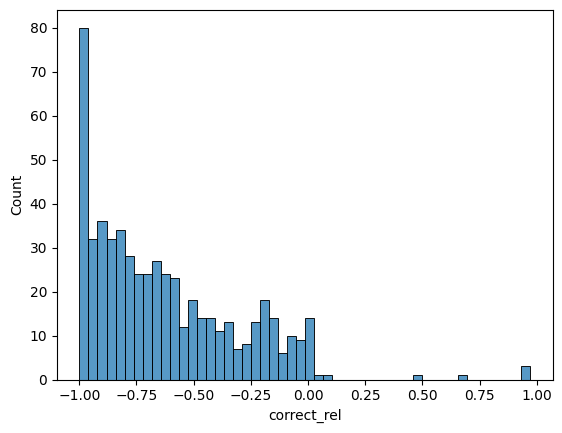

In [17]:
sns.histplot(data["correct_rel"], bins = 50)

## Pipeline

In [18]:
gradient_data

,0_grad_1,1_grad_1,2_grad_1,3_grad_1,4_grad_1,5_grad_1,6_grad_1,7_grad_1,8_grad_1,9_grad_1,...,993_grad_100,994_grad_100,995_grad_100,996_grad_100,997_grad_100,998_grad_100,999_grad_100,FlashType,sex,age
0,1.321870,-8.086971,-22.517879,-17.818781,-37.583360,-19.642548,-38.760297,-22.499234,-44.250137,-21.390546,...,0.773231,1.197564,2.145456,-1.313221,0.327119,-1.550599,-1.815611,1,0,19.6
1,1.321870,-8.086971,-22.517879,-17.818781,-37.583360,-19.642548,-38.760297,-22.499234,-44.250137,-21.390546,...,0.773231,1.197564,2.145456,-1.313221,0.327119,-1.550599,-1.815611,2,0,19.6
2,0.986680,-16.828001,-34.136189,-35.076566,-48.208476,-20.057158,-43.915446,-34.035360,-45.557241,-38.791309,...,0.773787,0.847120,1.121367,-0.590106,-1.745514,-1.058497,-0.530009,1,1,21.0
3,0.986680,-16.828001,-34.136189,-35.076566,-48.208476,-20.057158,-43.915446,-34.035360,-45.557241,-38.791309,...,0.773787,0.847120,1.121367,-0.590106,-1.745514,-1.058497,-0.530009,2,1,21.0
4,-3.722246,-6.377671,-21.773225,-12.073862,-28.036408,-13.546772,-21.425066,-12.509692,-20.292611,-12.981412,...,0.157389,0.754923,1.280207,-1.075791,0.102371,-0.093004,-1.245963,1,0,21.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,-2.091280,-7.909951,-17.140309,-14.940505,-34.980578,-19.110125,-30.900588,-18.702903,-38.587175,-32.760253,...,-2.312467,-0.156705,1.751729,0.225514,-1.552880,0.185838,0.848414,2,1,24.7
512,-1.283807,-4.730903,-21.511209,-24.237367,-31.481633,-12.693384,-31.002088,-34.534399,-30.549874,-27.876900,...,1.088504,0.841617,-0.326486,-2.062214,-1.251641,-0.961272,-1.696489,1,0,23.8
513,-1.283807,-4.730903,-21.511209,-24.237367,-31.481633,-12.693384,-31.002088,-34.534399,-30.549874,-27.876900,...,1.088504,0.841617,-0.326486,-2.062214,-1.251641,-0.961272,-1.696489,2,0,23.8
514,0.800421,1.150828,-27.663592,-17.034550,-50.619843,-17.965791,-55.846692,-54.930230,-53.847596,-48.121413,...,0.169269,1.776943,2.038685,-0.240898,-0.029213,0.704002,0.808477,1,0,21.5


In [19]:
cat_features = ['FlashType', 'sex']
grad_features = gradient_data.columns.tolist()[:-3]
age = ['age']


In [20]:
whiten = Pipeline(
    steps = [("whiten", StandardScaler())]
)

cat_encoder = Pipeline(
    steps = [("cat_encoder", OneHotEncoder(handle_unknown="ignore"))]
)

pca = Pipeline(
    steps = [("whiten", StandardScaler()),
             ('pca', PCA(n_components = 0.2))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("cat_encoder", cat_encoder, cat_features),
        ("whiten", whiten, age),
        ("pca", pca, grad_features)
    ]
)



In [21]:
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
svr = svm.SVR(kernel = "linear", epsilon = 0.2)
svr_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('svr', svr)
])

rf = RandomForestRegressor(random_state=42)

# Define the pipeline with Random Forests
rf_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', rf)
])

gb = GradientBoostingRegressor(random_state=42)
gb_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('gb', gb)
])

from sklearn.linear_model import QuantileRegressor
qr = QuantileRegressor(quantile=0.9, alpha=0, solver='highs')
qr_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('qr', qr)
])

In [22]:
X_train, X_test, y_train, y_test = train_test_split(gradient_data, correct_rel, test_size=0.25, random_state=42)

In [23]:
cv = KFold(n_splits = 5, shuffle = True, random_state = 42)
cv_results = cross_validate(svr_pipe, X_train, y_train, cv=cv, scoring=['r2', 'neg_mean_squared_error'], return_estimator =True, n_jobs = -1)

In [24]:
print("Mean R2 across folds: ", np.mean(cv_results['test_r2']))
print("Mean MSE across folds: ", np.mean(cv_results['test_neg_mean_squared_error']))

Mean R2 across folds:  0.15733590298267258
Mean MSE across folds:  -0.09394694634714662


In [11]:
coefs = pd.read_csv("coefs_grads_pca.csv")

In [25]:
coefs = pd.DataFrame(
    [
        est[-1].coef_[0] * est[:-1].transform(X_train.iloc[train_idx]).std(axis=0)
        for est, (train_idx, _) in zip(cv_results["estimator"], cv.split(X_train, y_train))
    ]
)

Text(0.5, 1.0, 'Coefficient importance and its variability')

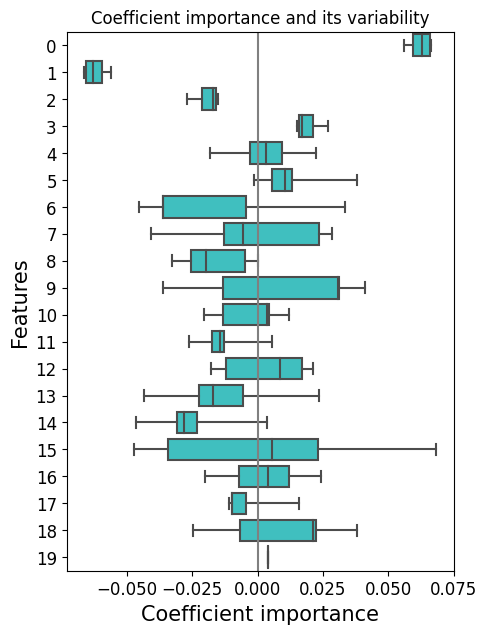

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )

fig, ax = plt.subplots(figsize=(5, 7))
sns.boxplot(data=coefs.iloc[:, :100], orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
ax.set_ylabel("Features", fontsize = 15)
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
ax.tick_params(axis='x', labelsize= 12) 
ax.tick_params(axis='y', labelsize= 12) 
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability")

## Check predictions

In [27]:
trained_model = svr_pipe.fit(X_train, y_train)

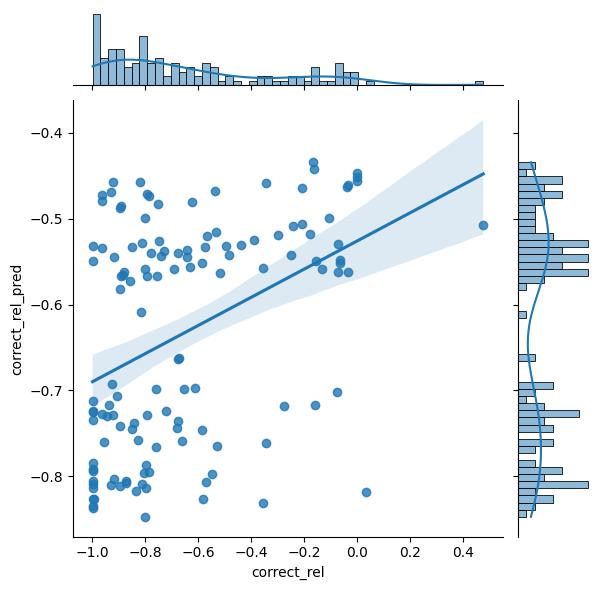

In [29]:
y_pred = trained_model.predict(X_test)
test_pred_df = pd.DataFrame({"correct_rel": y_test, "correct_rel_pred": y_pred})
sns.jointplot(data=test_pred_df, x="correct_rel", y="correct_rel_pred", kind="reg", marginal_kws={'bins': 50})

<Axes: xlabel='correct_rel_pred', ylabel='Count'>

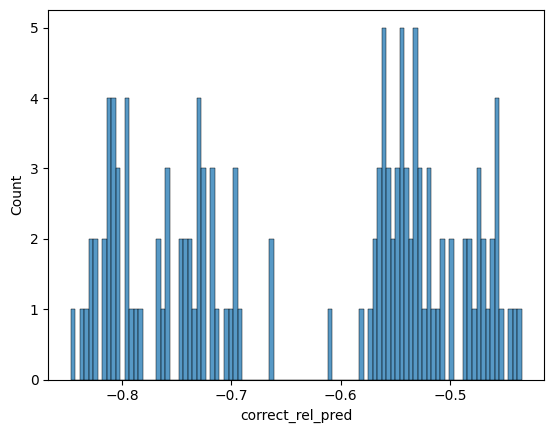

In [30]:
sns.histplot(test_pred_df["correct_rel_pred"], bins = 100)

## Model diagnostics

In [28]:
y_train_pred = trained_model.predict(X_train)

In [29]:
from sklearn.metrics import r2_score

print("R squared: {}".format(r2_score(y_true=y_train,y_pred=y_train_pred)))

R squared: 0.21339258848020404


In [30]:
residuals = y_train.values-y_train_pred
mean_residuals = np.mean(residuals)
print("Mean of Residuals {}".format(mean_residuals))

Mean of Residuals 0.005483241615934408


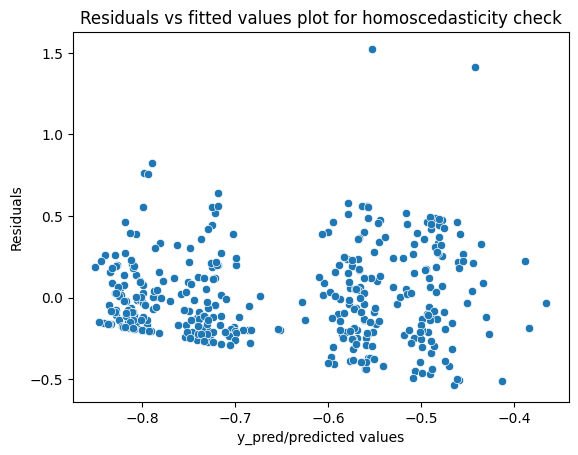

In [31]:
residuals_train = pd.DataFrame({"y_train_pred": y_train_pred, "residuals": residuals})

p = sns.scatterplot(residuals_train, x = "y_train_pred", y = "residuals")
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')
p = plt.title('Residuals vs fitted values plot for homoscedasticity check')

In [47]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(residuals, X_train)
lzip(name, test)

[('F statistic', 1.0388048724004102), ('p-value', 0.3559351667869693)]

## Permutation feature importance

In [32]:
from sklearn.inspection import permutation_importance

perm_acc = permutation_importance(trained_model, X_test, y_test,n_repeats=10000, random_state=42, n_jobs = -1)
perm_sorted_idx = perm_acc.importances_mean
perm_std = perm_acc.importances_std
null_dist_coefs = perm_acc.importances

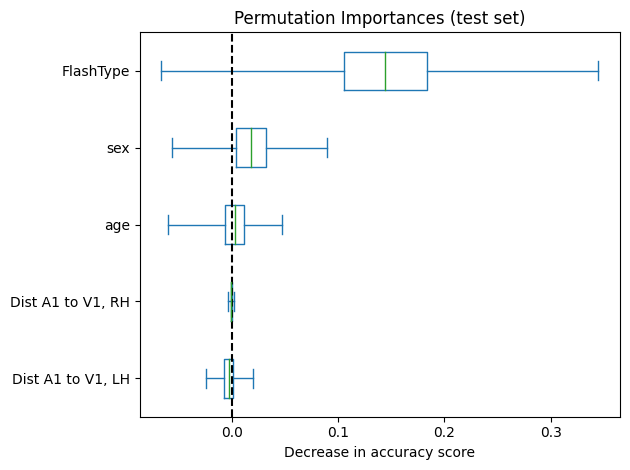

In [33]:
sorted_importances_idx = perm_acc.importances_mean.argsort()
importances = pd.DataFrame(
    perm_acc.importances[sorted_importances_idx].T,
    columns=X_train.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()